<div style="font-size:30px" align="center"> <b> Visualizing Word2Vec Models Trained on Biomedical Abstracts in PubMed </b> </div>
<div style="font-size:22px" align="center"> <b> A Comparison of Race and Diversity Over Time </b> </div>
<br>

<div style="font-size:18px" align="center"> <b> Brandon Kramer - University of Virginia's Biocomplexity Institute </b> </div>

<br>

This notebook explores two Word2Vec models trained the PubMed database taken from January 2021. Overall, I am interested in testing whether diversity and racial terms are becoming more closely related over time. To do this, I [trained](https://github.com/brandonleekramer/diversity/blob/master/src/04_word_embeddings/03_train_word2vec.ipynb) two models (one from 1990-2000 data and then a random sample of the 2010-2020 data). Now, I will visualize the results of these models to see which words are similar to race/diversity as well as plotting some comparisons of these two terms over time.

For those unfamiliar with Word2Vec, it might be worth reading [this post from Connor Gilroy](https://ccgilroy.github.io/community-discourse/introduction.html) - a sociologist that details how word embeddings can help us better understand the concept of "community." The post contains information on how Word2Vec and other word embedding approaches can teach us about word/document similarity, opposite words, and historical changes in words. Basically, Word2Vec turns all of the words in the corpus into a number based on how they are used in the context of 5-word windows (a parameter I defined in this model), making all of the words directly compariable to one another within a vector space. The end result is that we are able to compare how similar or different words are or, as we will see below, how similar or different words become over time. As we will come to see, this approach is useful but not perfect for dealing with our case due to the polysemy of 'diversity.'

#### Import packages and ingest data 

Let's load all of our packages and the `.bin` files that hold our models. 

In [1]:
# load packages
import os
from itertools import product
import pandas.io.sql as psql
import pandas as pd
from pandas import DataFrame
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Rectangle
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# load data 
os.chdir("/sfs/qumulo/qhome/kb7hp/git/diversity/data/word_embeddings/")
earlier_model = Word2Vec.load("word2vec_1990_2000_socdiv_0821.bin")
later_model_original = Word2Vec.load("word2vec_2010_2020_socdiv_0821.bin")

#### Normalizing Our Results

In [2]:
# http://www-personal.umich.edu/~tdszyman/misc/InsightSIGNLP16.pdf
# https://github.com/williamleif/histwords
# https://gist.github.com/zhicongchen/9e23d5c3f1e5b1293b16133485cd17d8 <<<<<<
# https://github.com/nikhgarg/EmbeddingDynamicStereotypes/blob/master/dataset_utilities/normalize_vectors.py

def intersection_align_gensim(m1, m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.index_to_key)
    vocab_m2 = set(m2.wv.index_to_key)

    # Find the common vocabulary
    common_vocab = vocab_m1 & vocab_m2
    if words: common_vocab &= set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1 - common_vocab and not vocab_m2 - common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.get_vecattr(w, "count") + m2.wv.get_vecattr(w, "count"), reverse=True)
    # print(len(common_vocab))

    # Then for each model...
    for m in [m1, m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.key_to_index[w] for w in common_vocab]
        old_arr = m.wv.vectors
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.vectors = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        new_key_to_index = {}
        new_index_to_key = []
        for new_index, key in enumerate(common_vocab):
            new_key_to_index[key] = new_index
            new_index_to_key.append(key)
        m.wv.key_to_index = new_key_to_index
        m.wv.index_to_key = new_index_to_key
        
        print(len(m.wv.key_to_index), len(m.wv.vectors))
        
    return (m1,m2)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """
    Original script: https://gist.github.com/quadrismegistus/09a93e219a6ffc4f216fb85235535faf
    Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
        
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """

    # patch by Richard So [https://twitter.com/richardjeanso) (thanks!) to update this code for new version of gensim
    # base_embed.init_sims(replace=True)
    # other_embed.init_sims(replace=True)

    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the (normalized) embedding matrices
    base_vecs = in_base_embed.wv.get_normed_vectors()
    other_vecs = in_other_embed.wv.get_normed_vectors()

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one, i.e. multiplying the embedding matrix by "ortho"
    other_embed.wv.vectors = (other_embed.wv.vectors).dot(ortho)    
    
    return other_embed

later_model = smart_procrustes_align_gensim(earlier_model, later_model_original)

78100 78100
78100 78100


#### Analyzing Most Similar Words 

**What words are most similar to "racial," "ethnicity", and "diversity"?** As we can see below, "racial" and "ethnicity" is mostly similar to other racialized and/or gendered terms in both the 1990-2000 and 2010-20 periods. "Diversity", on the other hand, is most similar to heterogeneity, divergence and complexity in 1990-2000 and then richness, divergence and diversification in 2010-2020. Overall, this tells us a different version of the same story we saw when analyzing Hypothesis 1: "diversity" rarely refers to social diversity along racial or classed lines. Diversity is mostly used as a biological term. Even here, richness, along with evenness, are measure within Simpson's Index for measuring ecological biodiversity (e.g. [Stirling et al. 2001](https://www.journals.uchicago.edu/doi/abs/10.1086/321317?casa_token=Fb4sojZm9XgAAAAA:BV-t4e5f3SZ05gTJZRUydcQvHTYg47f1qRu51CixgF-b_HnGVXuPQFaqf_Lp88Tvy51Gnp7iw4yG)). 

In [29]:
# average of earlier model 
earlier_race = earlier_model.wv.most_similar(positive=['race', 'racial', 'racially'], topn=50)
earlier_race = pd.DataFrame(earlier_race).rename(columns={0: "term", 1: "score"})
earlier_race['year'] = '1990-2000'
earlier_race.reset_index(inplace=True)
earlier_race = earlier_race.rename(columns = {'index':'rank'})

# average of later model 
later_race = later_model.wv.most_similar(positive=['race', 'racial', 'racially'], topn=50)
later_race = pd.DataFrame(later_race).rename(columns={0: "term", 1: "score"})
later_race['year'] = '2010-2020'
later_race.reset_index(inplace=True)
later_race = later_race.rename(columns = {'index':'rank'})

# merge the tables for comparison 
top_race_vectors = pd.merge(earlier_race, later_race, on=["rank"])
top_race_vectors

,rank,term_x,score_x,year_x,term_y,score_y,year_y
0,0,ethnic,0.746080,1990-2000,ethnicity,0.647613,2010-2020
1,1,ethnicity,0.743910,1990-2000,hispanic,0.623243,2010-2020
2,2,hispanic,0.666360,1990-2000,ethnic,0.607412,2010-2020
3,3,africanamerican,0.633400,1990-2000,nativity,0.585166,2010-2020
4,4,africanamericans,0.629658,1990-2000,africanamerican,0.582132,2010-2020
5,5,nonwhite,0.622604,1990-2000,nonwhite,0.578048,2010-2020
6,6,asian,0.615988,1990-2000,black,0.570823,2010-2020
7,7,afro,0.615607,1990-2000,africanamericans,0.567075,2010-2020
8,8,nativeamerican,0.607734,1990-2000,latino,0.566803,2010-2020
9,9,black,0.604130,1990-2000,minoritygroups,0.559057,2010-2020


In [4]:
# average of earlier model 
earlier_ethnicity = earlier_model.wv.most_similar(positive=['ethnic', 'ethnicity', 'ethnically'], topn=50)
earlier_ethnicity = pd.DataFrame(earlier_ethnicity).rename(columns={0: "term", 1: "score"})
earlier_ethnicity['year'] = '1990-2000'
earlier_ethnicity.reset_index(inplace=True)
earlier_ethnicity = earlier_ethnicity.rename(columns = {'index':'rank'})

# average of later model 
later_ethnicity = later_model.wv.most_similar(positive=['ethnic', 'ethnicity', 'ethnically'], topn=50)
later_ethnicity = pd.DataFrame(later_ethnicity).rename(columns={0: "term", 1: "score"})
later_ethnicity['year'] = '2010-2020'
later_ethnicity.reset_index(inplace=True)
later_ethnicity = later_ethnicity.rename(columns = {'index':'rank'})

# merge the tables for comparison 
top_ethnicity_vectors = pd.merge(earlier_ethnicity, later_ethnicity, on=["rank"])
top_ethnicity_vectors

,rank,term_x,score_x,year_x,term_y,score_y,year_y
0,0,racial,0.682590,1990-2000,racially,0.605639,2010-2020
1,1,race,0.656745,1990-2000,nationality,0.593144,2010-2020
2,2,hispanic,0.654482,1990-2000,puerto_rican,0.588783,2010-2020
3,3,nativeamerican,0.641869,1990-2000,asianamerican,0.573516,2010-2020
4,4,nationality,0.641251,1990-2000,pakistani,0.569005,2010-2020
5,5,racially,0.626523,1990-2000,nativity,0.562596,2010-2020
6,6,asian,0.620828,1990-2000,hispanic,0.562137,2010-2020
7,7,ancestry,0.615737,1990-2000,arab,0.557257,2010-2020
8,8,puerto_rican,0.605909,1990-2000,amerindian,0.551501,2010-2020
9,9,tribe,0.600957,1990-2000,moroccan,0.549968,2010-2020


In [5]:
# average of earlier model 
earlier_diversity = earlier_model.wv.most_similar(positive=['diverse', 'diversity'], topn=50)
earlier_diversity = pd.DataFrame(earlier_diversity).rename(columns={0: "term", 1: "score"})
earlier_diversity['year'] = '1990-2000'
earlier_diversity.reset_index(inplace=True)
earlier_diversity = earlier_diversity.rename(columns = {'index':'rank'})

# average of later model 
later_diversity = later_model.wv.most_similar(positive=['diverse', 'diversity'], topn=50)
later_diversity = pd.DataFrame(later_diversity).rename(columns={0: "term", 1: "score"})
later_diversity['year'] = '2010-2020'
later_diversity.reset_index(inplace=True)
later_diversity = later_diversity.rename(columns = {'index':'rank'})

# merge the tables for comparison 
top_diversity_vectors = pd.merge(earlier_diversity, later_diversity, on=["rank"])
top_diversity_vectors

,rank,term_x,score_x,year_x,term_y,score_y,year_y
0,0,socialdiversity,0.678314,1990-2000,socialdiversity,0.688373,2010-2020
1,1,socialdiverse,0.660211,1990-2000,socialdiverse,0.668614,2010-2020
2,2,divergent,0.535857,1990-2000,diversified,0.578688,2010-2020
3,3,unique,0.509646,1990-2000,diversification,0.513436,2010-2020
4,4,diversification,0.498368,1990-2000,variety,0.499657,2010-2020
5,5,heterogeneity,0.489784,1990-2000,heterogeneous,0.495402,2010-2020
6,6,divergence,0.478058,1990-2000,unique,0.477601,2010-2020
7,7,distinct,0.475096,1990-2000,distinct,0.474841,2010-2020
8,8,broader,0.470736,1990-2000,prokaryote,0.468980,2010-2020
9,9,evolutionary,0.470386,1990-2000,divergent,0.464818,2010-2020


#### Comparing Race and Diversity 

That makes it a little difficult to directly compare the terms, so let's use the `wv.similarity()` function to directly look at that. This basically allows you to directly compare the two words to see how close they are in the vector space. To make this process a little more efficient, we are going to make our own function named `w2v_similarities_over_time()` and then compare all the relevant terms. Following [Garg et al. (2018)](https://www.pnas.org/content/115/16/E3635.short), we also decided to average some of the terms in our dictionaries since it gets a little cumbersome trying to interpret the multiple outcomes of very similiary terms like diversity/diverse, race/racial, ethnic/ethnicity, etc. 

In [6]:
def w2v_similarities_over_time(df, w2v_m1, w2v_m2):
    ''' 
    function compares several word2vec vectors from two different years 
    and then examines how those several comparisons change over time  
    ----------------------------------------------------------------
    1) first it takes a dictionary of words and creates its product
    2) compares all of those words within the vector space of w2v_m1
    3) compares all of those words within the vector space of w2v_m2
    4) examines changes in the comparisons of w2v_m1 and w2v_m2 over time 
    
    '''
    df = list(product(df['term'], df['term']))
    df = pd.DataFrame(df, columns=['term1','term2'])
    
    cos_sim_m1 = []
    for index, row in df.iterrows():
        cos_sim_m1.append(w2v_m1.wv.similarity(row[0],row[1]))
    cos_sim_m1 = DataFrame(cos_sim_m1, columns=['cos_sim_m1'])
    df = df.merge(cos_sim_m1, left_index=True, right_index=True) 
    
    cos_sim_m2 = []
    for index, row in df.iterrows():
        cos_sim_m2.append(w2v_m2.wv.similarity(row[0],row[1]))
    cos_sim_m2 = DataFrame(cos_sim_m2, columns=['cos_sim_m2'])
    df = df.merge(cos_sim_m2, left_index=True, right_index=True)
    df["cos_sim_diffs"] = df["cos_sim_m1"] - df["cos_sim_m2"]
    
    df_matrix = df.pivot("term1", "term2", "cos_sim_diffs")
    return df_matrix

Let's pull in our dictionaries but filter to only the race and diversity entries:

In [7]:
race_diversity_early = earlier_model.wv.similarity('race','diversity')
race_diversity_later = later_model.wv.similarity('race','diversity')
racial_diversity_early = earlier_model.wv.similarity('racial','diversity')
racial_diversity_later = later_model.wv.similarity('racial','diversity')
ethnic_diversity_early = earlier_model.wv.similarity('ethnic','diversity')
ethnic_diversity_later = later_model.wv.similarity('ethnic','diversity')
ethnicity_diversity_early = earlier_model.wv.similarity('ethnicity','diversity')
ethnicity_diversity_later = later_model.wv.similarity('ethnicity','diversity')
black_div_early = earlier_model.wv.similarity('black','diversity')
black_div_later = later_model.wv.similarity('black','diversity')
afam_div_early = earlier_model.wv.similarity('africanamerican','diversity')
afam_div_later = later_model.wv.similarity('africanamerican','diversity')
white_div_early = earlier_model.wv.similarity('white','diversity')
white_div_later = later_model.wv.similarity('white','diversity')
caucasian_div_early = earlier_model.wv.similarity('caucasian','diversity')
caucasian_div_later = later_model.wv.similarity('caucasian','diversity')
hisp_div_early = earlier_model.wv.similarity('hispanic','diversity')
hisp_div_later = later_model.wv.similarity('hispanic','diversity')
asian_div_early = earlier_model.wv.similarity('asian','diversity')
asian_div_later = later_model.wv.similarity('asian','diversity')
latino_div_early = earlier_model.wv.similarity('latino','diversity')
latino_div_later = later_model.wv.similarity('latino','diversity')
native_div_early = earlier_model.wv.similarity('native','diversity')
native_div_later = later_model.wv.similarity('native','diversity')

print('Overall Comparisons of Racial and Diversity Terms:')
print('Race and diversity:             1990-2000 score:', race_diversity_early, '   2010-2020 score:', race_diversity_later, ' Difference is:', race_diversity_later-race_diversity_early )
print('Racial and diversity:           1990-2000 score:', racial_diversity_early, '   2010-2020 score:', racial_diversity_later, '  Difference is:', racial_diversity_later-racial_diversity_early)
print('Ethnic and diversity:           1990-2000 score:', ethnic_diversity_early, '   2010-2020 score:', ethnic_diversity_later, '  Difference is:', ethnic_diversity_later-ethnic_diversity_early)
print('Ethnicity and diversity:        1990-2000 score:', ethnicity_diversity_early, '   2010-2020 score:', ethnicity_diversity_later, '  Difference is:', ethnicity_diversity_later-ethnicity_diversity_early)
print('Black and diversity:            1990-1995 score:', black_div_early, '    2015-2020 score:', black_div_later, ' Difference is:', black_div_later-black_div_early)
print('African American and diversity: 1990-1995 score:', afam_div_early, '   2015-2020 score:', afam_div_later, ' Difference is:', afam_div_later-afam_div_early)
print('White and diversity:            1990-1995 score:', white_div_early, '  2015-2020 score:', white_div_later, '  Difference is:', white_div_later-white_div_early)
print('Caucasian and diversity:        1990-1995 score:', caucasian_div_early, '  2015-2020 score:', caucasian_div_later, '  Difference is:', caucasian_div_later-caucasian_div_early)
print('Hispanic and diversity:         1990-1995 score:', hisp_div_early, '   2015-2020 score:', hisp_div_later, '  Difference is:', hisp_div_later-hisp_div_early)
print('Latino and diversity:           1990-1995 score:', latino_div_early, '   2015-2020 score:', latino_div_later, '  Difference is:', latino_div_later-latino_div_early)
print('Asian and diversity:            1990-1995 score:', asian_div_early, '   2015-2020 score:', asian_div_later, '  Difference is:', asian_div_later-asian_div_early)
print('Native and diversity:           1990-1995 score:', native_div_early, '   2015-2020 score:', native_div_later, '  Difference is:', native_div_early-native_div_later)

Overall Comparisons of Racial and Diversity Terms:
Race and diversity:             1990-2000 score: 0.06736891    2010-2020 score: 0.03890419  Difference is: -0.02846472
Racial and diversity:           1990-2000 score: 0.23084037    2010-2020 score: 0.13509005   Difference is: -0.09575032
Ethnic and diversity:           1990-2000 score: 0.2257958    2010-2020 score: 0.17736048   Difference is: -0.04843533
Ethnicity and diversity:        1990-2000 score: 0.094476104    2010-2020 score: 0.074991494   Difference is: -0.01948461
Black and diversity:            1990-1995 score: 0.030569227     2015-2020 score: 0.05853094  Difference is: 0.027961714
African American and diversity: 1990-1995 score: 0.054992154    2015-2020 score: 0.04329457  Difference is: -0.011697583
White and diversity:            1990-1995 score: -0.0026508104   2015-2020 score: 0.028805513   Difference is: 0.03145632
Caucasian and diversity:        1990-1995 score: 0.15436253   2015-2020 score: 0.02839091   Difference is

To interpret these scores, we have to know that a value of 1 means that two words have a perfect relationship, 0 means the two words have no relationship, and -1 means that they are perfect opposites ([Stack Overflow 2017](https://stackoverflow.com/questions/42381902/interpreting-negative-word2vec-similarity-from-gensim), [Google Groups 2019](https://groups.google.com/g/gensim/c/SZ1yct-7CuU)). Thus, when we compare all of the race, racial, ethnic and ethnicity vectors to diverse and diversity, we actually see that they are becoming *less* similar over time. Thus, despite our earlier hypotheses indicating that diversity is rising while racial terms decline, it does not seem to be the case that the two are being used in similar ways over time. It is worth noting that a number of things could complicate this interpretation, including the polysemy of diversity. 

Next, we will create a plot for this. We have to keep this grey scale, because sociologists are still living in the late 1900s. 

Before moving on to plots of these vectors, let's take a look at specific racial terms and see how they compare to diversity. 

Text(0.5, 0, 'Cosine Similarity Scores')

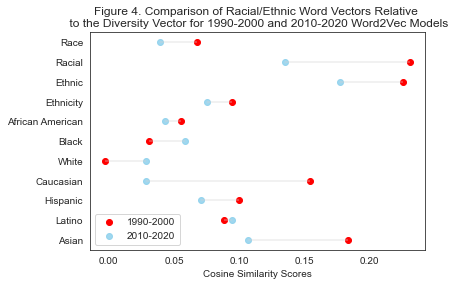

In [8]:
plt.figure(figsize=(6, 4))
sns.set_style("white")
d = {'group': [
    'Asian', 'Latino', 'Hispanic', 'Caucasian', 'White',
    'Black', 'African American', 'Ethnicity', 'Ethnic', 'Racial', 'Race'
    ],   
     '1990-2000': [
         asian_div_early, latino_div_early, hisp_div_early, caucasian_div_early, white_div_early,
         black_div_early, afam_div_early, ethnicity_diversity_early, ethnic_diversity_early, racial_diversity_early, race_diversity_early
     ], 
     '2010-2020': [
         asian_div_later, latino_div_later, hisp_div_later, caucasian_div_later, white_div_later,
         black_div_later, afam_div_later, ethnicity_diversity_later, ethnic_diversity_later, racial_diversity_later, race_diversity_later
     ]}
df = pd.DataFrame(data=d)
ordered_df = df

my_range=range(1,len(df.index)+1)

plt.hlines(y=my_range, xmin=ordered_df['1990-2000'], xmax=ordered_df['2010-2020'], color='lightgrey', alpha=0.4)
plt.scatter(ordered_df['1990-2000'], my_range, color='red', alpha=1, label='1990-2000')
plt.scatter(ordered_df['2010-2020'], my_range, color='skyblue', alpha=0.8 , label='2010-2020')
#plt.scatter(ordered_df['1990-2000'], my_range, color='black', alpha=1, label='1990-2000')
#plt.scatter(ordered_df['2010-2020'], my_range, color='dimgrey', alpha=0.4 , label='2010-2020')
plt.legend()
 
# Add title and axis names
plt.yticks(my_range, ordered_df['group'])
plt.title("Figure 4. Comparison of Racial/Ethnic Word Vectors Relative \n to the Diversity Vector for 1990-2000 and 2010-2020 Word2Vec Models", loc='center')
plt.xlabel('Cosine Similarity Scores')
#plt.ylabel('All Terms Compared to Diversity')

In [9]:
top_race_vectors.to_csv('/sfs/qumulo/qhome/kb7hp/git/diversity/data/final_data/race_vectors_alldiv_0921.csv')
top_ethnicity_vectors.to_csv('/sfs/qumulo/qhome/kb7hp/git/diversity/data/final_data/ethnicity_vectors_alldiv_0921.csv')
top_diversity_vectors.to_csv('/sfs/qumulo/qhome/kb7hp/git/diversity/data/final_data/diversity_vectors_alldiv_0921.csv')
ordered_df.to_csv('/sfs/qumulo/qhome/kb7hp/git/diversity/data/final_data/select_wv_comps_alldiv_0921.csv')

Overall, this approach gave us some mixed results. Asian and diversity/diverse become significantly more dissimilar while white and diversity/diverse become more similar. Once could argue that this supports Berrey's argument about diversity being used to reinforce whiteness, but it also might just be diverse/diversity being more to describe variation in neuroscience where a common term is 'white matter.' In the end, it might just be the case that the Word2Vec model's inability to deal with polysemy does not help us answer our research question. Before concluding that, let's look at visual plots of our vectors. 

#### Singular Value Decomposition 

In order to do that, we have to reduce the 512 dimension model into just 2 dimensions using the `TSNE` package. We will do this for both models, which will take around 30 minutes to run. Scroll down to see the results...

In [9]:
%%capture
earlier_vocab = list(earlier_model.wv.vocab)
earlier_x = earlier_model[earlier_vocab]
earlier_tsne = TSNE(n_components=2)
earlier_tsne_x = earlier_tsne.fit_transform(earlier_x)
df_earlier = pd.DataFrame(earlier_tsne_x, index=earlier_vocab, columns=['x', 'y'])

later_vocab = list(later_model.wv.vocab)
later_x = later_model[later_vocab]
later_tsne = TSNE(n_components=2)
later_tsne_x = later_tsne.fit_transform(later_x)
df_later = pd.DataFrame(later_tsne_x, index=later_vocab, columns=['x', 'y'])

keys = ['race', 'racial', 'ethnic', 'ethnicity', 'diverse', 'diversity']

earlier_embedding_clusters = []
earlier_word_clusters = []
for word in keys:
    earlier_embeddings = []
    earlier_words = []
    for similar_word, _ in earlier_model.wv.most_similar(word, topn=30):
        earlier_words.append(similar_word)
        earlier_embeddings.append(earlier_model[similar_word])
    earlier_embedding_clusters.append(earlier_embeddings)
    earlier_word_clusters.append(earlier_words)
    
earlier_embedding_clusters = np.array(earlier_embedding_clusters)
n, m, k = earlier_embedding_clusters.shape
e_tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
e_embeddings_en_2d = np.array(e_tsne_model_en_2d.fit_transform(earlier_embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

later_embedding_clusters = []
later_word_clusters = []
for word in keys:
    later_embeddings = []
    later_words = []
    for similar_word, _ in later_model.wv.most_similar(word, topn=30):
        later_words.append(similar_word)
        later_embeddings.append(later_model[similar_word])
    later_embedding_clusters.append(later_embeddings)
    later_word_clusters.append(later_words)
    
later_embedding_clusters = np.array(later_embedding_clusters)
n, m, k = later_embedding_clusters.shape
l_tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
l_embeddings_en_2d = np.array(l_tsne_model_en_2d.fit_transform(later_embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

AttributeError: The vocab attribute was removed from KeyedVector in Gensim 4.0.0.
Use KeyedVector's .key_to_index dict, .index_to_key list, and methods .get_vecattr(key, attr) and .set_vecattr(key, attr, new_val) instead.
See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4

#### Plotting the Results of the Word2Vec Models (1990-95 vs 2015-20)

In [ ]:
def tsne_plot_similar_words(title, labels, earlier_embedding_clusters, earlier_word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, earlier_embeddings, earlier_words, color in zip(labels, earlier_embedding_clusters, earlier_word_clusters, colors):
        x = earlier_embeddings[:, 0]
        y = earlier_embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(earlier_words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()
    
early_plot = tsne_plot_similar_words('Comparing the Use of Race, Ethnicity and Diversity (Word2Vec Model of 1990-2000 PubMed Data)', 
                        keys, e_embeddings_en_2d, earlier_word_clusters, 0.7, 'earlier_comparison.png')
early_plot

Now we can look at how the words in each vector of race, racial, ethnic, ethnicity, diversity and diverse. When we start to look at the specific terms of interest, we find racial and ethnic are the far left or toward the bottom-center. Other variants of these terms are more centered in the plot. On the other hand, diversity and diverse are both clustered toward the top-right, which means that race and diversity are fairly far away in the vector space.

In [ ]:
def tsne_plot_similar_words(title, labels, later_embedding_clusters, later_word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, later_embeddings, later_words, color in zip(labels, later_embedding_clusters, later_word_clusters, colors):
        x = later_embeddings[:, 0]
        y = later_embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(later_words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


later_plot = tsne_plot_similar_words('Comparing the Use of Race, Ethnicity and Diversity (Word2Vec Model of 2010-2020 PubMed Data)', 
                        keys, l_embeddings_en_2d, later_word_clusters, 
                        0.7, 'later_comparison.png')

os.chdir("/sfs/qumulo/qhome/kb7hp/git/diversity/data/word_embeddings/")
plt.savefig('later_comparison.png')
later_plot

When we look at the same vectors in the 2015-20 model, it seems like the vectors are more closely related overall. However, when we look closer we see that the 'race' and 'ethnicity' are up in the top-left corner while 'racial' and 'ethnic' are in the top-right corner. Both sets are still fairly separated from the red and orange diversity vectors. Although these plots do not show this as clear as one might want, our analyses above do suggest that diverse and diversity as well as race, racial, ethnic, and ethinicity are being used more dissimilarly over time. The challenging thing about this analysis disentangling the polysemy from how diversity is used. If we were able to 'disentange' the use of diveristy in its more general sense compared to its usage in the context of equity, inclusion and justice discussions, would we find that the two words are becoming more similar over time? 

#### Does diversity replace race/ethnicity?: Contextualizing Word Vectors with Heat Maps

After consulting some colleagues, we thought about two potential ways to test this. The first would be to turn to BERT or ELMo ([Fonteyn 2019](https://laurenthelinguist.files.wordpress.com/2019/08/sle_2019_bert.pdf); [Rakhmanberdieva 2019](https://towardsdatascience.com/word-representation-in-natural-language-processing-part-iii-2e69346007f)), which would allow us to identify the contexual variations in how diversity is used. The problem is that BERT, for example, is trained on Wikipedia data that is not historical. There are BERT options like PubMedBERT and BioBERT, but they are trained on the entirety of the PubMed abstracts, which fails to help us identify historical variations in how the terms change. Moreover, it would not make much sense to fine tune a BERT model on the same data in which it was already trained on. Thus, we ruled out BERT as an option. 

Instead, we decided to continue using Word2Vec and instead compare the diveristy vector to a myriad of other vectors that we measured in H1. Our logic was that if we see diversity become more semantically similar to other diversity-related vectors over time time, while also moving further away from the racial/ethic vectors, we could infer that diversity is actually replacing race/ethnicity in biomedical abstracts over time. 

To do this, I developed a function named `w2v_similarities_over_time()` that calculates the difference between all the words witin a dictionary of terms and then compares how they have changed relative to one another over time. Specifically, I will be comparing how diverse and diversity change relative to the terms in our race/ethnicity, sex/gender, sexuality, social class, and cultural/equity categories from [Hypotheses 1 and 2](https://growthofdiversity.netlify.app/methods/). Then, I will visualize the results of these models comparisons using some heat maps.

First step is importing our H1 library so we can pluck out all of the vectors for a heat map in a relatively automated manner.

In [10]:
# load dictionary of words 
os.chdir("/sfs/qumulo/qhome/kb7hp/git/diversity/data/dictionaries/")
h1_dictionary = pd.read_csv("diversity_project - tree_data.csv")
h1_dictionary = h1_dictionary[h1_dictionary['viz_embeddings'] == 1].drop(['hypothesis', 'viz_embeddings', 'mean_embeddings'], axis=1)
h1_dictionary = h1_dictionary.replace({'category': {'asian|black|hispanic_latinx|white': 'race_ethnicity'}}, regex=True)
h1_dictionary = h1_dictionary.replace({'category': {'sex_gender|sexuality': 'gender_sexuality'}}, regex=True)
h1_dictionary = h1_dictionary.replace({'category': {'cultural|equity': 'cultural_equity'}}, regex=True)
h1_dictionary = h1_dictionary.replace({'category': {'minority': 'social_class'}}, regex=True).sort_values(by=['category', 'term'])
h1_dictionary = h1_dictionary.replace({'term': {'under_served': 'underserved'}}, regex=True).sort_values(by=['category', 'term'])
h1_dictionary = h1_dictionary.replace({'term': {'african_american': 'africanamerican'}}, regex=True).sort_values(by=['category', 'term'])
# manual deletion after chatting with catherine 
h1_dictionary =  h1_dictionary[~h1_dictionary['term'].isin(['diverse', 'negro', 'ethnic', 'racist', 'racial',
                                                  'homosexual', 'men', 'women', 'inequality', 'equality'])]
h1_dictionary

,category,term
0,ancestry,admixture
2,ancestry,ancestor
4,ancestry,ancestral
6,ancestry,ancestry
7,ancestry,background
...,...,...
440,social_class,suburban
450,social_class,underprivileged
203,social_class,underrepresented
452,social_class,underserved


Next, we will define our `w2v_similarities_over_time()` function.

In [11]:
def w2v_similarities_over_time(df, w2v_m1, w2v_m2):
    ''' 
    function compares several word2vec vectors from two different years 
    and then examines how those several comparisons change over time  
    ----------------------------------------------------------------
    1) first it takes a dictionary of words and creates its product
    2) compares all of those words within the vector space of w2v_m1
    3) compares all of those words within the vector space of w2v_m2
    4) examines changes in the comparisons of w2v_m1 and w2v_m2 over time 
    
    '''
    df = list(product(df['term'], df['term']))
    df = pd.DataFrame(df, columns=['term1','term2'])
    
    cos_sim_m1 = []
    for index, row in df.iterrows():
        cos_sim_m1.append(w2v_m1.wv.similarity(row[0],row[1]))
    cos_sim_m1 = DataFrame(cos_sim_m1, columns=['cos_sim_m1'])
    df = df.merge(cos_sim_m1, left_index=True, right_index=True) 
    
    cos_sim_m2 = []
    for index, row in df.iterrows():
        cos_sim_m2.append(w2v_m2.wv.similarity(row[0],row[1]))
    cos_sim_m2 = DataFrame(cos_sim_m2, columns=['cos_sim_m2'])
    df = df.merge(cos_sim_m2, left_index=True, right_index=True)
    df["cos_sim_diffs"] = df["cos_sim_m2"] - df["cos_sim_m1"]
    df_matrix = df.pivot("term1", "term2", "cos_sim_diffs")
    return df_matrix

And check to make sure we get the same results as above... 

In [12]:
race_ethnicity = h1_dictionary[(h1_dictionary['category'] == 'race_ethnicity') | 
                               (h1_dictionary['category'] == 'diversity')]
race_ethnicity_matrix = w2v_similarities_over_time(race_ethnicity, earlier_model, later_model)
race_ethnicity_matrix

term2,africanamerican,asian,biracial,black,caucasian,diversity,ethnicity,hispanic,latino,multiethnic,multiracial,race,racism,white
term1,,,,,,,,,,,,,,
africanamerican,0.000000,-0.175731,-0.079913,-0.070209,-0.053105,-0.011698,-4.270595e-02,-0.052962,-0.075466,-0.059309,1.619472e-01,-0.004164,-0.004135,-0.037449
asian,-0.175731,0.000000,-0.107805,-0.214430,-0.056969,-0.077072,1.395494e-03,-0.224231,-0.220591,-0.072268,4.347399e-02,-0.100173,-0.129660,-0.157356
biracial,-0.079913,-0.107805,0.000000,-0.035492,-0.078622,-0.021266,-2.873196e-02,-0.100811,-0.118934,-0.077682,-9.206414e-03,0.030516,-0.097156,-0.052419
black,-0.070209,-0.214430,-0.035492,0.000000,-0.099765,0.027962,-6.024656e-02,-0.033792,-0.065168,-0.055667,2.322823e-01,-0.013465,0.038425,-0.001050
caucasian,-0.053105,-0.056969,-0.078622,-0.099765,0.000000,-0.125972,1.406953e-01,-0.087822,-0.117813,-0.061242,1.565471e-01,0.016340,-0.118079,-0.008837
diversity,-0.011698,-0.077072,-0.021266,0.027962,-0.125972,0.000000,-1.948461e-02,-0.028549,0.006436,0.017349,1.831765e-02,-0.028465,-0.007810,0.031456
ethnicity,-0.042706,0.001395,-0.028732,-0.060247,0.140695,-0.019485,5.960464e-08,-0.039400,0.003392,-0.008348,7.279435e-02,-0.091031,-0.110258,0.001544
hispanic,-0.052962,-0.224231,-0.100811,-0.033792,-0.087822,-0.028549,-3.939992e-02,0.000000,-0.017725,-0.150491,9.935051e-02,0.027726,-0.030865,-0.021489
latino,-0.075466,-0.220591,-0.118934,-0.065168,-0.117813,0.006436,3.392249e-03,-0.017725,0.000000,-0.075141,1.755719e-01,0.042250,0.089735,-0.067096


These do look similar to the basic plot we created above.

So now we will create each of our four heat maps and combine them into a joint figure for publication (again in grey scale for the sociologists)...

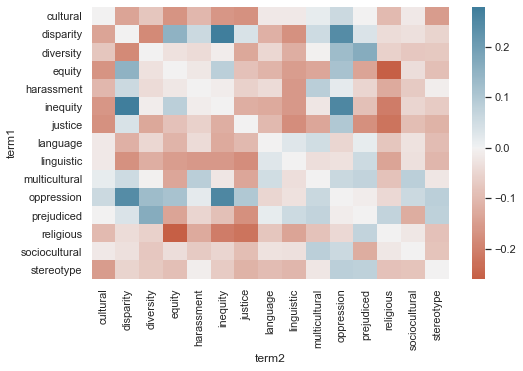

In [13]:
sns.set(rc={'figure.figsize':(8,5)})
sns.set_style("whitegrid")
cultural_equity = h1_dictionary[(h1_dictionary['category'] == 'cultural_equity') | 
                                (h1_dictionary['category'] == 'diversity')]
cultural_equity =  cultural_equity[~cultural_equity['term'].isin(['interlinguistic', 'oppressive', 'religion', 'religiosity'])]

cultural_equity_matrix = w2v_similarities_over_time(cultural_equity, earlier_model, later_model)
cmap = sns.diverging_palette(20, 230, as_cmap=True)
#cmap = sns.cubehelix_palette(200, hue=0.05, rot=0, light=0, dark=0.9)
#corr_cultural = cultural_equity_matrix.corr()
#mask_cultural = np.triu(np.ones_like(corr_cultural, dtype=bool))
cultural_equity_heatmap = sns.heatmap(cultural_equity_matrix, center=0, #mask=mask_cultural, 
                                      cmap=cmap)

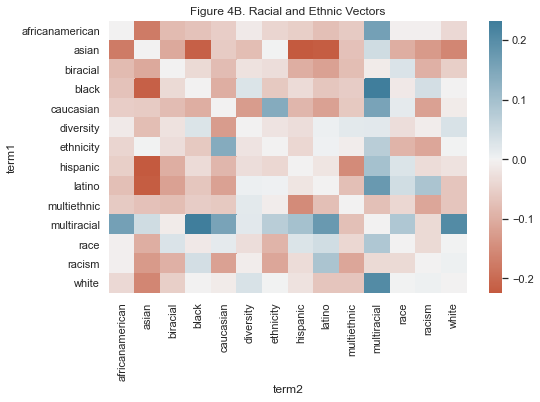

In [14]:
race_ethnicity = h1_dictionary[(h1_dictionary['category'] == 'race_ethnicity') | 
                               (h1_dictionary['category'] == 'diversity')]
race_ethnicity_matrix = w2v_similarities_over_time(race_ethnicity, earlier_model, later_model)
#corr_race = race_ethnicity_matrix.corr()
#mask_race = np.triu(np.ones_like(corr_race, dtype=bool))
race_ethnicity_heatmap = sns.heatmap(race_ethnicity_matrix, #mask=mask_race, 
                                     center=0, cmap=cmap).set_title("Figure 4B. Racial and Ethnic Vectors")

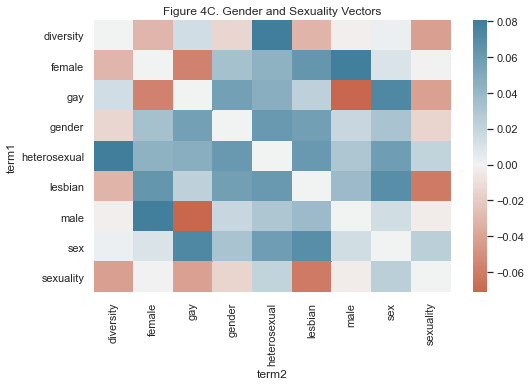

In [15]:
gender_sexuality = h1_dictionary[(h1_dictionary['category'] == 'gender_sexuality') | 
                                 (h1_dictionary['category'] == 'diversity')]
gender_sexuality_matrix = w2v_similarities_over_time(gender_sexuality, earlier_model, later_model)
#corr_gender = gender_sexuality_matrix.corr()
#mask_gender = np.triu(np.ones_like(corr_gender, dtype=bool))
gender_sexuality_heatmap = sns.heatmap(gender_sexuality_matrix, center=0, #mask=mask_gender, 
                                       cmap=cmap).set_title("Figure 4C. Gender and Sexuality Vectors")

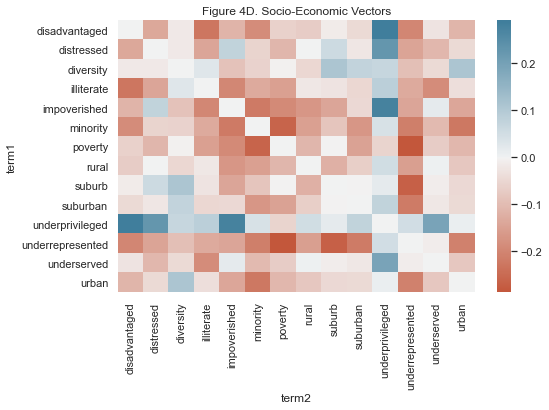

In [16]:
social_class = h1_dictionary[(h1_dictionary['category'] == 'social_class') | 
                             (h1_dictionary['category'] == 'diversity')]
social_class_matrix = w2v_similarities_over_time(social_class, earlier_model, later_model)
#corr_class = social_class_matrix.corr()
#mask_class = np.triu(np.ones_like(corr_class, dtype=bool))
social_class_heatmap = sns.heatmap(social_class_matrix, center=0, #mask=mask_class, 
                                   cmap=cmap).set_title("Figure 4D. Socio-Economic Vectors")

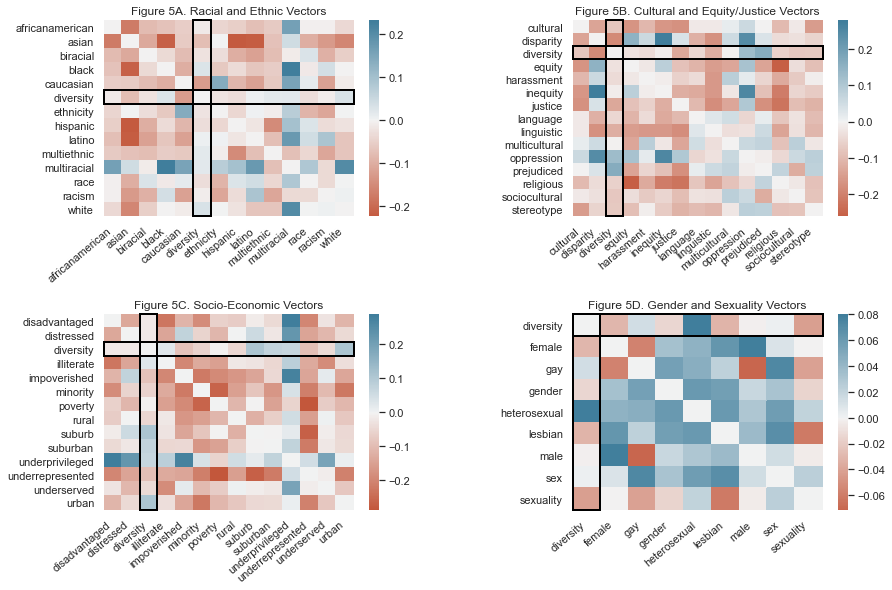

In [17]:
sns.set(rc={'figure.figsize':(14,9)})
sns.set_style("whitegrid")
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, constrained_layout=False)

# race/ethnicity
race_ethnicity_g = sns.heatmap(race_ethnicity_matrix, center=0, cmap=cmap, ax=ax1)
race_ethnicity_labels = race_ethnicity['term'].sort_values().tolist()
N = len(race_ethnicity_labels)
race_label = 'diversity'
race_index = race_ethnicity_labels.index(race_label)
x, y, w, h = 0, race_index, N, 1
for _ in range(2):
    race_ethnicity_g.add_patch(Rectangle((x, y), w, h, fill=False, edgecolor='black', lw=2, clip_on=False))
    x, y, w, h = y, x, h, w 
race_ethnicity_g.set_title("Figure 5A. Racial and Ethnic Vectors")
race_ethnicity_g.set(xlabel=None)
race_ethnicity_g.set(ylabel=None)
race_ethnicity_g.set_xticklabels(race_ethnicity_g.get_xticklabels(), rotation=40, horizontalalignment='right')

## cultural
cultural_equity_g = sns.heatmap(cultural_equity_matrix, center=0, cmap=cmap, ax=ax2)
cultural_labels = cultural_equity['term'].sort_values().tolist()
N = len(cultural_labels)
cultural_label = 'diversity'
cultural_index = cultural_labels.index(cultural_label)
x, y, w, h = 0, cultural_index, N, 1
for _ in range(2):
    cultural_equity_g.add_patch(Rectangle((x, y), w, h, fill=False, edgecolor='black', lw=2, clip_on=False))
    x, y, w, h = y, x, h, w 
cultural_equity_g.set_title("Figure 5B. Cultural and Equity/Justice Vectors")
cultural_equity_g.set(xlabel=None)
cultural_equity_g.set(ylabel=None)
cultural_equity_g.set_xticklabels(cultural_equity_g.get_xticklabels(), rotation=40, horizontalalignment='right')

# socio-economic 
social_class_g = sns.heatmap(social_class_matrix, center=0, cmap=cmap, ax=ax3)
ses_labels = social_class['term'].sort_values().tolist()
N = len(ses_labels)
ses_label = 'diversity'
ses_index = ses_labels.index(ses_label)
x, y, w, h = 0, ses_index, N, 1
for _ in range(2):
    social_class_g.add_patch(Rectangle((x, y), w, h, fill=False, edgecolor='black', lw=2, clip_on=False))
    x, y, w, h = y, x, h, w 
social_class_g.set_title("Figure 5C. Socio-Economic Vectors")
social_class_g.set(xlabel=None)
social_class_g.set(ylabel=None)
social_class_g.set_xticklabels(social_class_g.get_xticklabels(), rotation=40, horizontalalignment='right')

# sex/gender
gender_sexuality_g = sns.heatmap(gender_sexuality_matrix, center=0, cmap=cmap, ax=ax4)
gender_labels = gender_sexuality['term'].sort_values().tolist()
N = len(gender_labels)
gender_label = 'diversity'
gender_index = gender_labels.index(gender_label)
x, y, w, h = 0, gender_index, N, 1
for _ in range(2):
    gender_sexuality_g.add_patch(Rectangle((x, y), w, h, fill=False, edgecolor='black', lw=2, clip_on=False))
    x, y, w, h = y, x, h, w 
gender_sexuality_g.set_title("Figure 5D. Gender and Sexuality Vectors")
gender_sexuality_g.set(xlabel=None)
gender_sexuality_g.set(ylabel=None)
gender_sexuality_g.set_xticklabels(gender_sexuality_g.get_xticklabels(), rotation=40, horizontalalignment='right')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)

The final product provides some interesting results. It sure looks like diversity is generally more similar to most of the vectors apart from the race/ethnicity vectors, which could suggest that diversity is replacing race/ethnicity within in the context of articles that are examining other historically underrepresented populations in biomedical research. 

In [18]:
# load dictionary of words 
os.chdir("/sfs/qumulo/qhome/kb7hp/git/diversity/data/dictionaries/")
national_terms = pd.read_csv("diversity_project - national_embeddings.csv")
national_terms.head()

,category,term
0,diversity,diversity
1,asian,asian
2,asian,chinese
3,asian,japan
4,asian,india


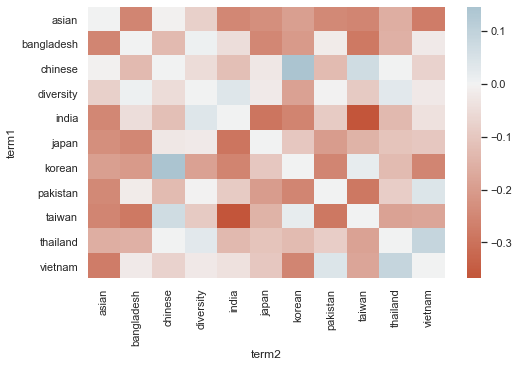

In [19]:
sns.set(rc={'figure.figsize':(8,5)})
sns.set_style("whitegrid")
national_asian = national_terms[(national_terms['category'] == 'asian') | 
                                (national_terms['category'] == 'diversity')]
national_asian_matrix = w2v_similarities_over_time(national_asian, earlier_model, later_model)
cmap = sns.diverging_palette(20, 230, as_cmap=True)
national_asian_heatmap = sns.heatmap(national_asian_matrix, center=0, cmap=cmap)

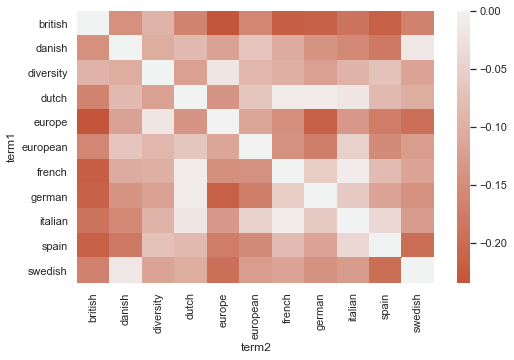

In [20]:
sns.set(rc={'figure.figsize':(8,5)})
sns.set_style("whitegrid")
national_europe = national_terms[(national_terms['category'] == 'europe') | 
                                (national_terms['category'] == 'diversity')]
national_europe_matrix = w2v_similarities_over_time(national_europe, earlier_model, later_model)
cmap = sns.diverging_palette(20, 230, as_cmap=True)
national_europe_heatmap = sns.heatmap(national_europe_matrix, center=0, cmap=cmap)

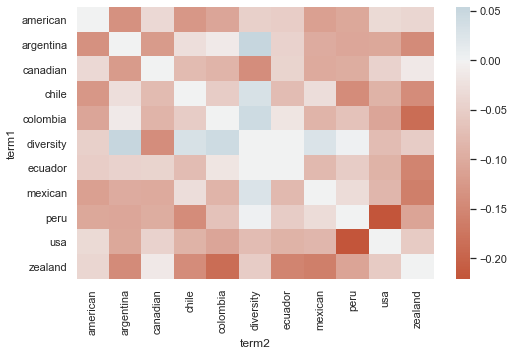

In [21]:
sns.set(rc={'figure.figsize':(8,5)})
sns.set_style("whitegrid")
national_americas = national_terms[(national_terms['category'] == 'americas') | 
                                (national_terms['category'] == 'diversity')]
national_americas_matrix = w2v_similarities_over_time(national_americas, earlier_model, later_model)
cmap = sns.diverging_palette(20, 230, as_cmap=True)
national_americas_heatmap = sns.heatmap(national_americas_matrix, center=0, cmap=cmap)

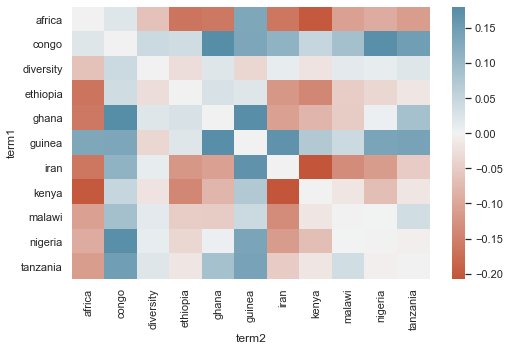

In [22]:
sns.set(rc={'figure.figsize':(8,5)})
sns.set_style("whitegrid")
national_africa = national_terms[(national_terms['category'] == 'africa') | 
                                (national_terms['category'] == 'diversity')]
national_africa_matrix = w2v_similarities_over_time(national_africa, earlier_model, later_model)
cmap = sns.diverging_palette(20, 230, as_cmap=True)
national_africa_heatmap = sns.heatmap(national_africa_matrix, center=0, cmap=cmap)

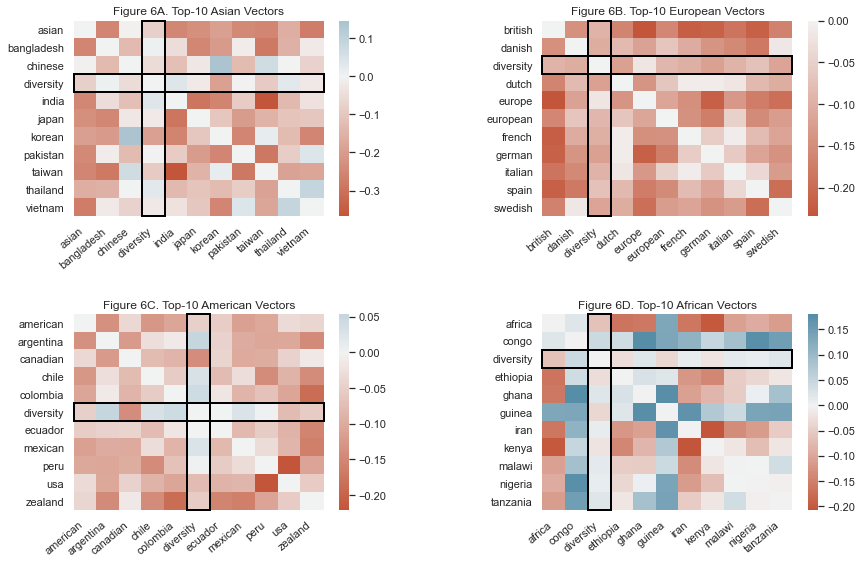

In [23]:
sns.set(rc={'figure.figsize':(14,9)})
sns.set_style("whitegrid")
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, constrained_layout=False)

## cultural
national_asian_g = sns.heatmap(national_asian_matrix, center=0, cmap=cmap, ax=ax1)
national_asian_labels = national_asian['term'].sort_values().tolist()
N = len(national_asian_labels)
national_asian_label = 'diversity'
national_asian_index = national_asian_labels.index(national_asian_label)
x, y, w, h = 0, national_asian_index, N, 1
for _ in range(2):
    national_asian_g.add_patch(Rectangle((x, y), w, h, fill=False, edgecolor='black', lw=2, clip_on=False))
    x, y, w, h = y, x, h, w 
national_asian_g.set_title("Figure 6A. Top-10 Asian Vectors")
national_asian_g.set(xlabel=None)
national_asian_g.set(ylabel=None)
national_asian_g.set_xticklabels(national_asian_g.get_xticklabels(), rotation=40, horizontalalignment='right')

# race/ethnicity
national_europe_g = sns.heatmap(national_europe_matrix, center=0, cmap=cmap, ax=ax2)
national_europe_labels = national_europe['term'].sort_values().tolist()
N = len(national_europe_labels)
national_europe_label = 'diversity'
national_europe_index = national_europe_labels.index(national_europe_label)
x, y, w, h = 0, national_europe_index, N, 1
for _ in range(2):
    national_europe_g.add_patch(Rectangle((x, y), w, h, fill=False, edgecolor='black', lw=2, clip_on=False))
    x, y, w, h = y, x, h, w 
national_europe_g.set_title("Figure 6B. Top-10 European Vectors")
national_europe_g.set(xlabel=None)
national_europe_g.set(ylabel=None)
national_europe_g.set_xticklabels(national_europe_g.get_xticklabels(), rotation=40, horizontalalignment='right')

# sex/gender
national_americas_g = sns.heatmap(national_americas_matrix, center=0, cmap=cmap, ax=ax3)
national_americas_labels = national_americas['term'].sort_values().tolist()
N = len(national_americas_labels)
national_americas_label = 'diversity'
national_americas_index = national_americas_labels.index(national_americas_label)
x, y, w, h = 0, national_americas_index, N, 1
for _ in range(2):
    national_americas_g.add_patch(Rectangle((x, y), w, h, fill=False, edgecolor='black', lw=2, clip_on=False))
    x, y, w, h = y, x, h, w 
national_americas_g.set_title("Figure 6C. Top-10 American Vectors")
national_americas_g.set(xlabel=None)
national_americas_g.set(ylabel=None)
national_americas_g.set_xticklabels(national_americas_g.get_xticklabels(), rotation=40, horizontalalignment='right')

# socio-economic 
national_africa_g = sns.heatmap(national_africa_matrix, center=0, cmap=cmap, ax=ax4)
national_africa_labels = national_africa['term'].sort_values().tolist()
N = len(national_africa_labels)
national_africa_label = 'diversity'
national_africa_index = national_africa_labels.index(national_africa_label)
x, y, w, h = 0, national_africa_index, N, 1
for _ in range(2):
    national_africa_g.add_patch(Rectangle((x, y), w, h, fill=False, edgecolor='black', lw=2, clip_on=False))
    x, y, w, h = y, x, h, w 
national_africa_g.set_title("Figure 6D. Top-10 African Vectors")
national_africa_g.set(xlabel=None)
national_africa_g.set(ylabel=None)
national_africa_g.set_xticklabels(national_africa_g.get_xticklabels(), rotation=40, horizontalalignment='right')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)

### Mean Differences 

Let's define a function that compares the mean differences for all terms within each category so that we can make better sense of the visualizations. 

In [24]:
def w2v_sim_mean_comps(df, w2v_m1, w2v_m2):

    df = list(product(df['term'], df['term']))
    df = pd.DataFrame(df, columns=['term1','term2'])
    
    cos_sim_m1 = []
    for index, row in df.iterrows():
        cos_sim_m1.append(w2v_m1.wv.similarity(row[0],row[1]))
    cos_sim_m1 = DataFrame(cos_sim_m1, columns=['cos_sim_m1'])
    df = df.merge(cos_sim_m1, left_index=True, right_index=True) 
    
    cos_sim_m2 = []
    for index, row in df.iterrows():
        cos_sim_m2.append(w2v_m2.wv.similarity(row[0],row[1]))
    cos_sim_m2 = DataFrame(cos_sim_m2, columns=['cos_sim_m2'])
    df = df.merge(cos_sim_m2, left_index=True, right_index=True)
    df["cos_sim_diffs"] = df["cos_sim_m2"] - df["cos_sim_m1"]
    
    return df

In [26]:
os.chdir("/sfs/qumulo/qhome/kb7hp/git/diversity/data/dictionaries/")
h1_allterms = pd.read_csv("diversity_project - tree_data.csv")
h1_allterms =  h1_allterms[h1_allterms['term'].isin(list(earlier_model.wv.key_to_index))]
h1_allterms['term'] = h1_allterms['term'].str.replace('_', '', regex=True)
#h1_allterms =  h1_allterms[~h1_allterms['term'].isin(['intersexual'])]

list_of_terms = ['cultural', 'disability', 'equity', 'lifecourse', 'migration', 
                 'minority', 'race_ethnicity', 'sex_gender', 'sexuality', 'social_class']

aggregated_means = pd.DataFrame(columns = ['term1', 'term2', 'cos_sim_m1', 'cos_sim_m2', 'cos_sim_diffs', 'group'])
for term in list_of_terms:
    tmp_dictionary = h1_allterms[(h1_allterms['category'] == term) | (h1_allterms['term'] == 'diversity')]
    comp_outcomes = w2v_sim_mean_comps(tmp_dictionary, earlier_model, later_model)
    comp_outcomes = comp_outcomes[(comp_outcomes['term1'] == 'diversity') & (comp_outcomes['term2'] != 'diversity')]
    comp_outcomes['group'] = [term] * len(comp_outcomes)
    aggregated_means = pd.concat([aggregated_means, comp_outcomes])
    
aggregated_means = aggregated_means.groupby(by=["group"]).mean().round(3)
aggregated_means.to_csv('/sfs/qumulo/qhome/kb7hp/git/diversity/data/final_data/alldiv_mean_h1_comps_0921.csv')
aggregated_means

,cos_sim_m1,cos_sim_m2,cos_sim_diffs
group,,,
cultural,0.173,0.123,-0.050
disability,0.013,-0.005,-0.018
equity,0.148,0.126,-0.022
lifecourse,-0.011,-0.015,-0.004
migration,0.113,0.102,-0.011
minority,0.175,0.160,-0.015
race_ethnicity,0.124,0.087,-0.037
sex_gender,0.036,0.037,0.001
sexuality,0.052,0.064,0.012


In [27]:
os.chdir("/sfs/qumulo/qhome/kb7hp/git/diversity/data/dictionaries/")
h3_dictionary = pd.read_csv("diversity_project - h3_dictionary.csv")
h3_dictionary =  h3_dictionary[h3_dictionary['term'].isin(list(earlier_model.wv.key_to_index))]
h3_dictionary = h3_dictionary.drop(['str_type','regional','subclass','source','date_added'], axis=1)
#h3_dictionary = h3_dictionary[h3_dictionary['category'] != 'subnational'] # need to update later 
#h3_dictionary = h3_dictionary[h3_dictionary['category'] != 'subcontinental'] # need to update later 

category_analysis = h3_dictionary.drop(['continental'], axis=1)
#category_analysis = category_analysis[category_analysis['mean_embeddings'] == 1]
#category_analysis = category_analysis.drop(['mean_embeddings'], axis=1)
#category_analysis = category_analysis[~category_analysis['term'].str.contains("s$")]
category_analysis = category_analysis[~category_analysis['term'].str.contains("_")]

os.chdir("/sfs/qumulo/qhome/kb7hp/git/diversity/data/dictionaries/")
h3_div_subset = pd.read_csv("diversity_project - tree_data.csv")
h3_div_subset = h3_div_subset.drop(['viz_embeddings','mean_embeddings','hypothesis'], axis=1)
h3_div_subset = h3_div_subset[h3_div_subset['category'] == 'diversity']
h3_div_subset = h3_div_subset[['term', 'category']]
category_analysis = pd.concat([category_analysis, h3_div_subset])
category_analysis

list_of_terms = ['continental', 'directional', 'national', 'omb/us census', 'race/ethnicity', 'subcontinental', 'subnational']

aggregated_means = pd.DataFrame(columns = ['term1', 'term2', 'cos_sim_m1', 'cos_sim_m2', 'cos_sim_diffs', 'group'])
for term in list_of_terms:
    tmp_dictionary = category_analysis[(category_analysis['category'] == term) | (category_analysis['term'] == 'diversity')]
    comp_outcomes = w2v_sim_mean_comps(tmp_dictionary, earlier_model, later_model)
    comp_outcomes = comp_outcomes[(comp_outcomes['term1'] == 'diversity') & (comp_outcomes['term2'] != 'diversity')]
    comp_outcomes['group'] = [term] * len(comp_outcomes)
    aggregated_means = pd.concat([aggregated_means, comp_outcomes])
    
aggregated_means = aggregated_means.groupby(by=["group"]).mean().round(3)
aggregated_means.to_csv('/sfs/qumulo/qhome/kb7hp/git/diversity/data/final_data/alldiv_mean_h3_comps_0921.csv')
aggregated_means


,cos_sim_m1,cos_sim_m2,cos_sim_diffs
group,,,
continental,0.146,0.150,0.004
directional,0.087,0.144,0.057
national,0.069,0.086,0.017
omb/us census,0.093,0.111,0.018
race/ethnicity,0.158,0.095,-0.063
subcontinental,0.089,0.102,0.014
subnational,0.045,0.071,0.026


In [28]:
os.chdir("/sfs/qumulo/qhome/kb7hp/git/diversity/data/dictionaries/")
h3_dictionary = pd.read_csv("diversity_project - h3_dictionary.csv")
h3_dictionary =  h3_dictionary[h3_dictionary['term'].isin(list(earlier_model.wv.key_to_index))]
h3_dictionary = h3_dictionary.drop(['str_type','regional','subclass','source','date_added'], axis=1)
national_means = h3_dictionary[h3_dictionary['category'] == 'national']
#national_means = national_means[national_means['mean_embeddings'] == 1]
national_means = national_means.drop(['category','mean_embeddings'], axis=1)
national_means = national_means.rename(columns={'continental': 'category'})
#national_means = national_means[~national_means['term'].str.contains("s$")]
national_means = national_means[~national_means['term'].str.contains("_")]
national_means = pd.concat([national_means, h3_div_subset])
national_means

list_of_terms = ['africa', 'asia', 'europe', 'north america', 'oceania', 'south america']

aggregated_means = pd.DataFrame(columns = ['term1', 'term2', 'cos_sim_m1', 'cos_sim_m2', 'cos_sim_diffs', 'group'])
for term in list_of_terms:
    tmp_dictionary = national_means[(national_means['category'] == term) | (national_means['term'] == 'diversity')]
    comp_outcomes = w2v_sim_mean_comps(tmp_dictionary, earlier_model, later_model)
    comp_outcomes = comp_outcomes[(comp_outcomes['term1'] == 'diversity') & (comp_outcomes['term2'] != 'diversity')]
    comp_outcomes['group'] = [term] * len(comp_outcomes)
    aggregated_means = pd.concat([aggregated_means, comp_outcomes])
    
aggregated_means = aggregated_means.groupby(by=["group"]).mean().round(3)
aggregated_means.to_csv('/sfs/qumulo/qhome/kb7hp/git/diversity/data/final_data/alldiv_mean_pop_comps_0921.csv')
aggregated_means
 

,cos_sim_m1,cos_sim_m2,cos_sim_diffs
group,,,
africa,0.056,0.098,0.041
asia,0.079,0.090,0.012
europe,0.064,0.053,-0.011
north america,0.073,0.098,0.025
oceania,0.053,0.086,0.033
south america,0.104,0.133,0.029


#### References

[Connor Gilroy's Tutorial](https://ccgilroy.github.io/community-discourse/word-similarity.html)

[Dominiek Ter Heide's Word2Vec Explorer](https://github.com/dominiek/word2vec-explorer)

[Sergey Smetanin's Medium Tutorial](https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d)

[Guru 99's Tutorial on Word Embeddings](https://www.guru99.com/word-embedding-word2vec.html)

[Rakhmanberdieva's 2019 Medium Post](https://towardsdatascience.com/word-representation-in-natural-language-processing-part-iii-2e69346007f)

[Fonteyn's 2019 Presentation](https://laurenthelinguist.files.wordpress.com/2019/08/sle_2019_bert.pdf)

[Bagheri's Medium Post on SVD](https://towardsdatascience.com/understanding-singular-value-decomposition-and-its-application-in-data-science-388a54be95d)

[Heatmap Highights](https://stackoverflow.com/questions/62533046/how-to-add-color-border-or-similar-highlight-to-specifc-element-of-heatmap-in-py)